In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from keras import layers
from keras.optimizer_v2.adam import Adam

import keras_transfer_learning as ktl

In [3]:
(x_train, y_train), (x_test, y_test), key = ktl.load_dataset('fmnist')

In [4]:
top_layers = [
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
]
model, base_model = ktl.build_model(
    model_name='resnet50', 
    input_shape=(32, 32), 
    top_layers=top_layers
)
model.compile(
    optimizer=Adam(learning_rate=1e-3), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "resnet50_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
initial_epochs = 20
fine_tune_epochs = 10

In [6]:
def augmentation_layer(x: tf.Tensor) -> tf.Tensor:
    x = tf.cast(x, dtype=tf.float32)
    x = tf.image.random_flip_left_right(x)

    return x

train_dataset, test_dataset = ktl.get_data_generators(x_train, y_train, x_test, y_test, augmentation_layer)

In [7]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=test_dataset,
)

Epoch 1/20
469/469 [==============================] - 82s 129ms/step - loss: 0.8867 - accuracy: 0.7152 - val_loss: 0.4833 - val_accuracy: 0.8275
Epoch 2/20
469/469 [==============================] - 56s 120ms/step - loss: 0.4610 - accuracy: 0.8338 - val_loss: 0.4574 - val_accuracy: 0.8380
Epoch 3/20
469/469 [==============================] - 56s 120ms/step - loss: 0.4209 - accuracy: 0.8483 - val_loss: 0.4406 - val_accuracy: 0.8437
Epoch 4/20
469/469 [==============================] - 56s 120ms/step - loss: 0.3916 - accuracy: 0.8554 - val_loss: 0.4475 - val_accuracy: 0.8425
Epoch 5/20
469/469 [==============================] - 56s 120ms/step - loss: 0.3817 - accuracy: 0.8616 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 6/20
469/469 [==============================] - 56s 120ms/step - loss: 0.3650 - accuracy: 0.8669 - val_loss: 0.4339 - val_accuracy: 0.8478
Epoch 7/20
469/469 [==============================] - 56s 120ms/step - loss: 0.3588 - accuracy: 0.8695 - val_loss: 0.4495 - val_ac

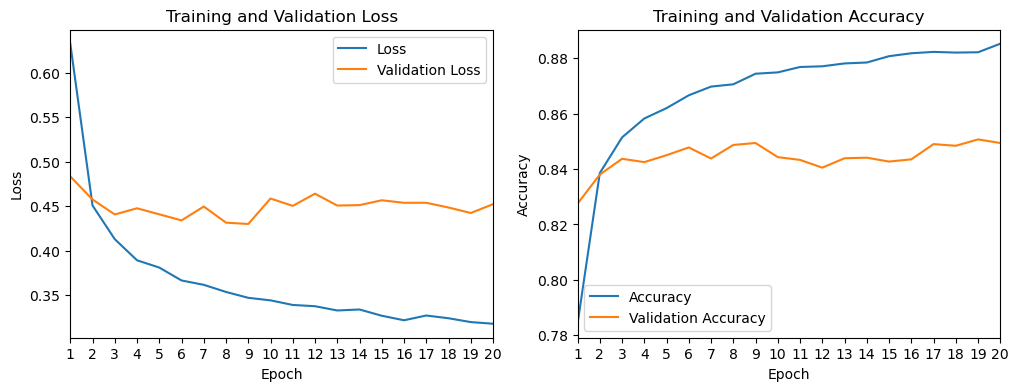

In [8]:
ktl.plot_history(history)

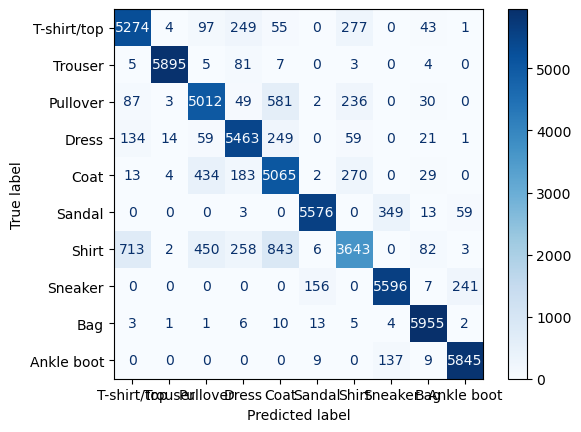

In [9]:
labels = [val for val in key.values()]
ktl.plot_confusion_matrix(model, x_train, y_train, labels)

In [10]:
ktl.unfreeze_model(model, base_model, 20, 1e-5)
model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "resnet50_transfer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 8,951,818
Non-trainable params: 14,656,384
_________________________________________________________________


In [11]:
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_dataset
)

Epoch 20/30
469/469 [==============================] - 43s 80ms/step - loss: 1.0199 - accuracy: 0.7669 - val_loss: 0.6861 - val_accuracy: 0.8123
Epoch 21/30
469/469 [==============================] - 36s 77ms/step - loss: 0.5301 - accuracy: 0.8403 - val_loss: 0.6281 - val_accuracy: 0.8223
Epoch 22/30
469/469 [==============================] - 37s 78ms/step - loss: 0.4247 - accuracy: 0.8601 - val_loss: 0.5704 - val_accuracy: 0.8309
Epoch 23/30
469/469 [==============================] - 41s 87ms/step - loss: 0.3620 - accuracy: 0.8761 - val_loss: 0.5420 - val_accuracy: 0.8341
Epoch 24/30
469/469 [==============================] - 36s 77ms/step - loss: 0.3169 - accuracy: 0.8871 - val_loss: 0.5267 - val_accuracy: 0.8412
Epoch 25/30
469/469 [==============================] - 36s 77ms/step - loss: 0.2910 - accuracy: 0.8958 - val_loss: 0.5122 - val_accuracy: 0.8439
Epoch 26/30
469/469 [==============================] - 36s 78ms/step - loss: 0.2665 - accuracy: 0.9033 - val_loss: 0.5025 - val_ac

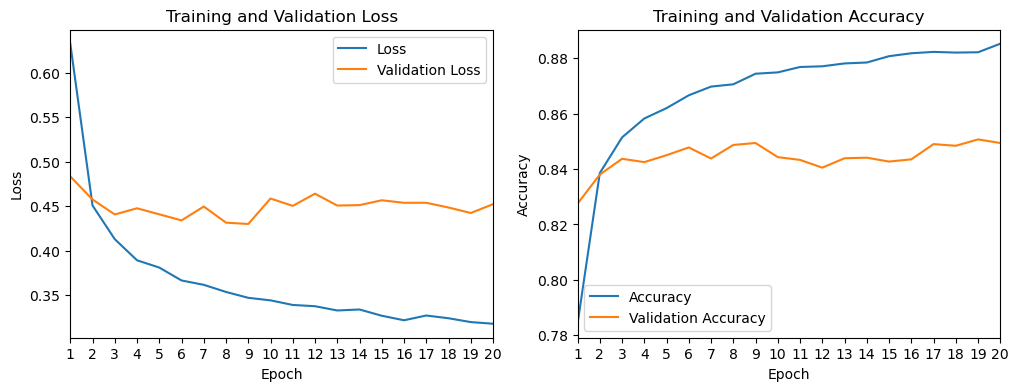

In [12]:
ktl.plot_history(history)

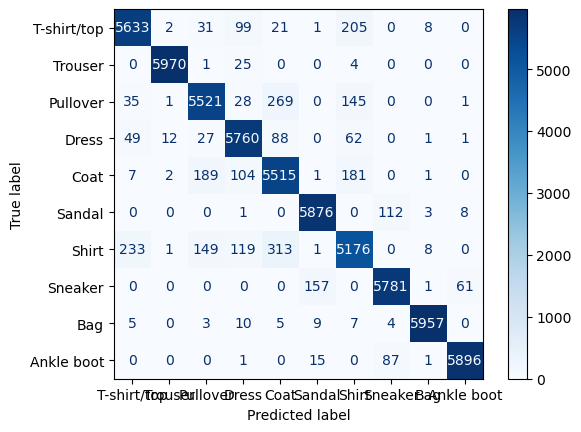

In [13]:
labels = [val for val in key.values()]
ktl.plot_confusion_matrix(model, x_train, y_train, labels)